In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
del y_train
del y_test
del mndata
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).reshape(-1,28,28,1)

In [4]:
import sys
sys.path.append("../dnn_from_scratch")

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 383
Seed: 855


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((7,7,128)))
    model.add(upsampling())
#     model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(upsampling())
#     model.add(dropout(0.25))
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(dropout(0.2))
    model.add(conv2d(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 14, 14, 128)        echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
5 Batch

In [7]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(28,28,1)))
    model.add(max_pool())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.25))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 28, 28, 32)         leakyRelu        320
__________________________________________________________________________________________
2 max_pool(max_pool)      (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 14, 14, 64)         leakyRelu        18496
__________________________________________________________________________________________
5 max_pool

In [8]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [9]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow(gen.reshape(28,28), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

In [10]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%60:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 2


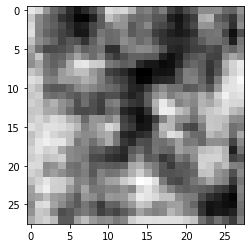

[0.456052]
Progress: 5.39 %     Dloss: 17.637683868408203    err: 0.03900305926799774     Sample time: 0.877s    ___

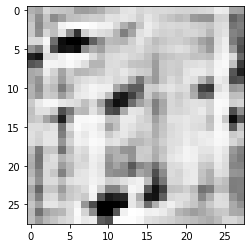

[1.8481395e-06]
Progress: 10.88 %     Dloss: 24.530065536499023    err: 0.02776125818490982     Sample time: 0.840s    __

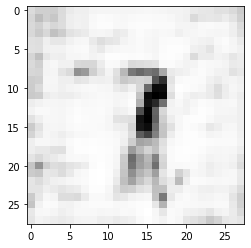

[0.04052353]
Progress: 16.37 %     Dloss: 25.182493209838867    err: 0.013269211165606976     Sample time: 0.858s    _

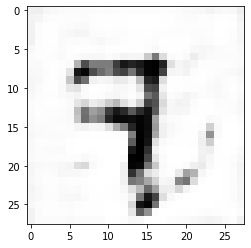

[0.02289252]
Progress: 21.85 %     Dloss: 33.70386505126953    err: 0.0070893531665205956     Sample time: 0.875s    __

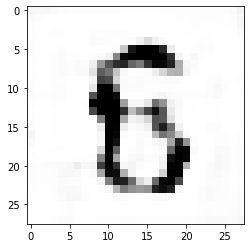

[0.12989414]
Progress: 27.34 %     Dloss: 35.40769958496094    err: 0.004937597084790468     Sample time: 0.829s    _ _

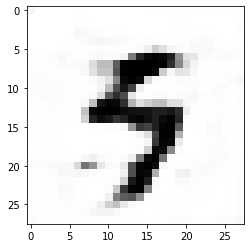

[0.11503054]
Progress: 32.82 %     Dloss: 32.577674865722656    err: 0.0039791930466890335     Sample time: 1.191s    _

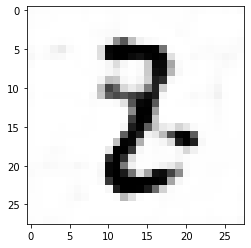

[0.07335772]
Progress: 38.31 %     Dloss: 31.491872787475586    err: 0.0049533722922205925     Sample time: 1.064s    _

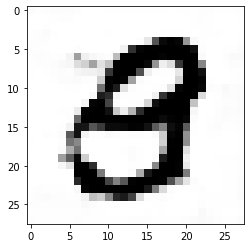

[0.01550201]
Progress: 43.79 %     Dloss: 42.09702682495117    err: 0.0036138135474175215     Sample time: 0.877s    __

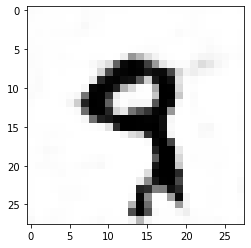

[0.07059183]
Progress: 49.28 %     Dloss: 40.23552703857422    err: 0.003574945731088519     Sample time: 0.879s    _ _

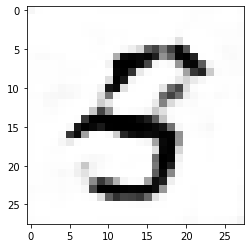

[0.2862943]
Progress: 54.77 %     Dloss: 34.65764617919922    err: 0.0036476710811257362     Sample time: 0.847s    __

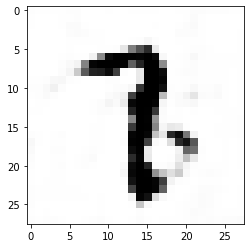

[0.0036398]
Progress: 60.25 %     Dloss: 33.595916748046875    err: 0.003661126596853137     Sample time: 0.847s    __

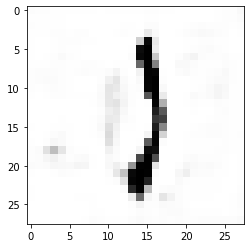

[0.15763818]
Progress: 65.74 %     Dloss: 35.76988983154297    err: 0.0035342504270374775     Sample time: 1.058s    __

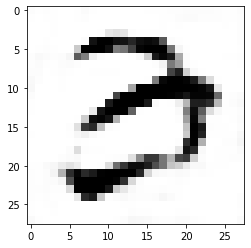

[0.00014291]
Progress: 71.22 %     Dloss: 34.12769317626953    err: 0.0032192093785852194     Sample time: 0.858s    __

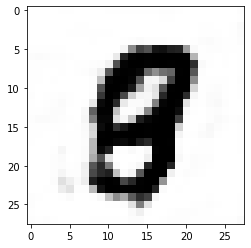

[0.2631952]
Progress: 76.71 %     Dloss: 32.69495391845703    err: 0.003280285280197859     Sample time: 0.850s    ___

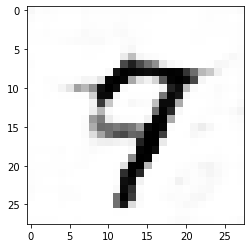

[0.16482113]
Progress: 82.19 %     Dloss: 36.796531677246094    err: 0.0031319099944084883     Sample time: 0.853s    _

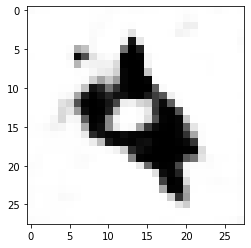

[0.02312523]
Progress: 87.68 %     Dloss: 39.49079132080078    err: 0.0033030349295586348     Sample time: 0.843s    __

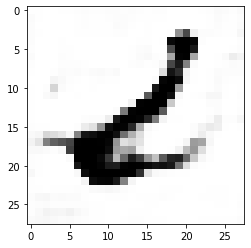

[0.00051242]
Progress: 93.17 %     Dloss: 41.33748245239258    err: 0.003242006991058588     Sample time: 2.238s    _ _

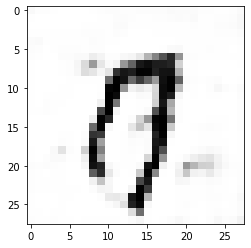

[0.02194418]
Progress: 98.65 %     Dloss: 34.497032165527344    err: 0.0031544058583676815     Sample time: 1.144s    _

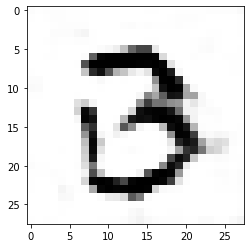

[0.03457919]
Progress: 99.84 %     Dloss: 39.71147918701172    err: 0.003296388080343604     Sample time: 1.172s    ___
Epoch time: 17:0s


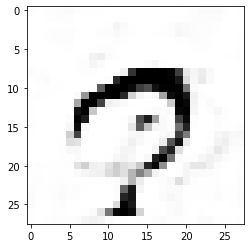

[0.01105533]
EPOCH: 2 / 2


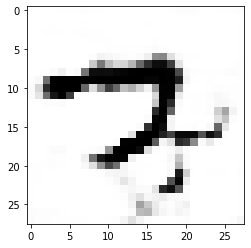

[2.3357527e-05]
Progress: 5.39 %     Dloss: 36.24155044555664    err: 0.003203159663826227     Sample time: 0.845s    ___

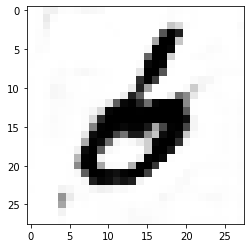

[0.01980585]
Progress: 10.88 %     Dloss: 36.07644271850586    err: 0.0035638504195958376     Sample time: 0.894s    __

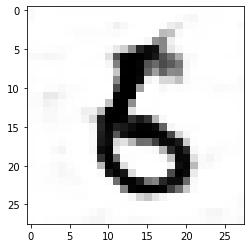

[0.01880083]
Progress: 16.37 %     Dloss: 32.08514404296875    err: 0.0038256810512393713     Sample time: 0.918s    __

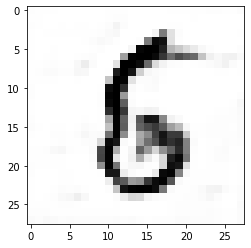

[0.07037547]
Progress: 21.85 %     Dloss: 32.14265441894531    err: 0.0035380255430936813     Sample time: 0.884s    __

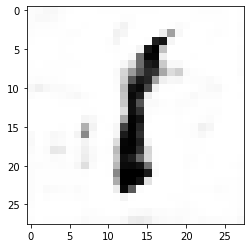

[0.17232247]
Progress: 27.34 %     Dloss: 34.09541320800781    err: 0.0036050784401595592     Sample time: 2.166s    __

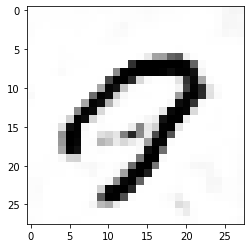

[0.02191485]
Progress: 32.82 %     Dloss: 41.338279724121094    err: 0.003657970577478409     Sample time: 2.109s    __

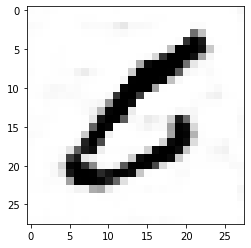

[0.00424362]
Progress: 38.31 %     Dloss: 33.601051330566406    err: 0.003709806129336357     Sample time: 2.035s    __

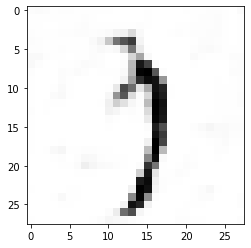

[0.00747242]
Progress: 43.79 %     Dloss: 36.97517776489258    err: 0.003732483834028244     Sample time: 2.096s    _ _

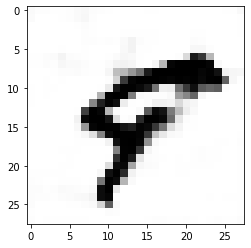

[4.811957e-05]
Progress: 49.28 %     Dloss: 38.400901794433594    err: 0.00390641437843442     Sample time: 2.084s    ___

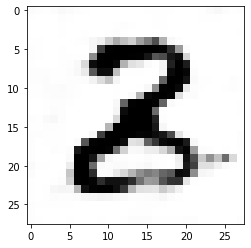

[0.00166052]
Progress: 54.77 %     Dloss: 38.37428283691406    err: 0.003924791235476732     Sample time: 1.962s    ___

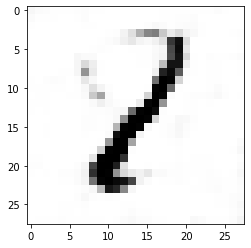

[0.01255631]
Progress: 60.25 %     Dloss: 38.5825080871582    err: 0.003925642464309931     Sample time: 1.946s    _ __

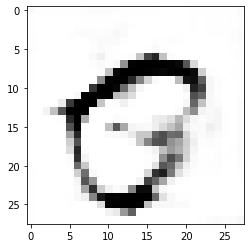

[0.00488288]
Progress: 65.74 %     Dloss: 38.52392578125    err: 0.0038617500104010105     Sample time: 1.852s    _ ___

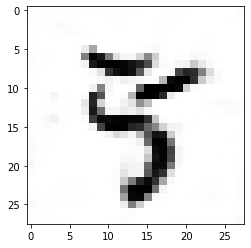

[0.00076435]
Progress: 71.22 %     Dloss: 35.08924102783203    err: 0.0037804136518388987     Sample time: 1.951s    __

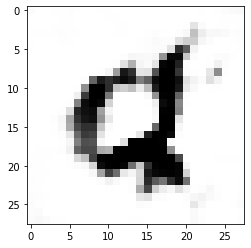

[0.0206406]
Progress: 76.71 %     Dloss: 35.09779739379883    err: 0.004685977473855019     Sample time: 1.857s    ___

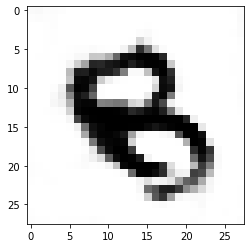

[0.00698319]
Progress: 82.19 %     Dloss: 40.90891647338867    err: 0.0038306049536913633     Sample time: 2.002s    __

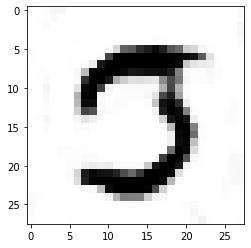

[0.00099162]
Progress: 87.68 %     Dloss: 34.42388916015625    err: 0.0037989048287272453     Sample time: 2.156s    __

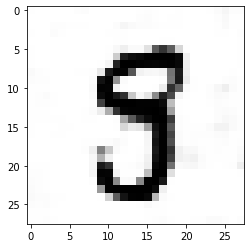

[0.00049519]
Progress: 93.17 %     Dloss: 39.91327667236328    err: 0.00374181498773396     Sample time: 2.171s    _ __

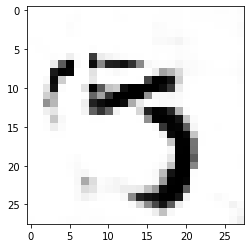

[0.0003682]
Progress: 98.65 %     Dloss: 41.429473876953125    err: 0.003849996952340007     Sample time: 2.070s    __

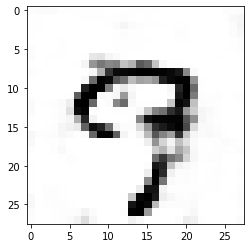

[0.00564028]
Progress: 99.84 %     Dloss: 33.29102325439453    err: 0.0038979288656264544     Sample time: 2.005s    __
Epoch time: 32:53s


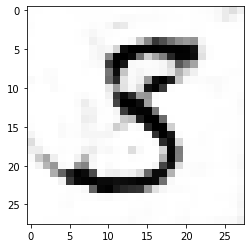

[0.00036909]


In [11]:
epochs=1
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

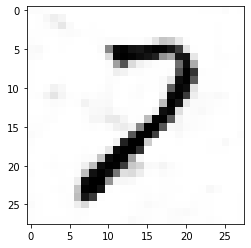

[0.00017462]


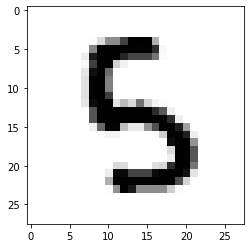

[[0.01580429]]


In [17]:
noise=np.random.randn(128,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow(img.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(img))

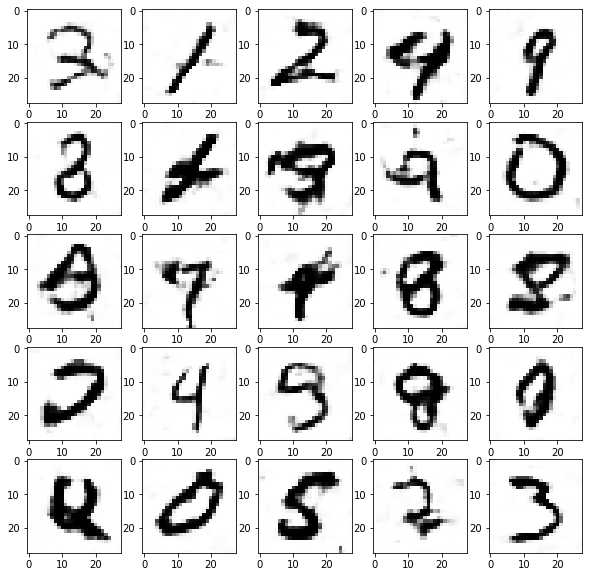

In [19]:
# Well after just 1 epoch
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow(gen[i].squeeze(), cmap='Greys')